# Дополнение данных для обучения глубоких нейросетей (data augmentation)

**Источник данных** - соревнования Kaggle [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data).

Для распознавания используется предварительно обученная сверточная нейронная сеть VGG16.

Перед использованием необходимо скачать и подготовить данные для обучения, проверки и тестирования. Можно использовать пример в ноутбуке data_preparation

In [55]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam
import matplotlib.pyplot as plt
from scipy.misc import toimage
%matplotlib inline 

In [56]:
# Каталог с данными для обучения
train_dir = 'small/train'
# Каталог с данными для проверки
val_dir = 'small/val'
# Каталог с данными для тестирования
test_dir = 'small/test'
# Размеры изображения
img_width, img_height = 150, 150
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 3)
# Размер мини-выборки
batch_size = 64
# Количество изображений для обучения
nb_train_samples = 17500
# Количество изображений для проверки
nb_validation_samples = 3750
# Количество изображений для тестирования
nb_test_samples = 3750

## Создаем генератор изображений

Генератор изображений создается на основе класса ImageDataGenerator. Генератор делит значения всех пикселов изображения на 255.

In [22]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

Проверяем работу генератора

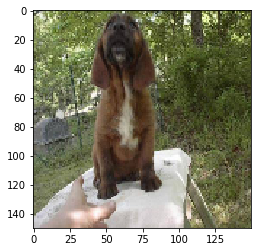

In [59]:
image_file_name = train_dir + '/dogs/dog.5.jpg'
img = image.load_img(image_file_name, target_size=(150, 150))
plt.imshow(img)

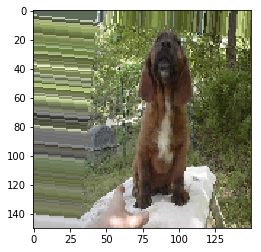

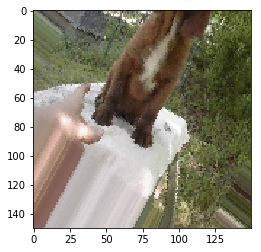

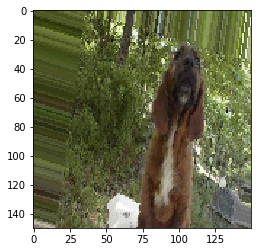

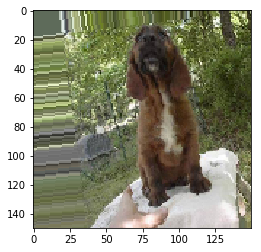

In [60]:
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

Генератор данных для обучения на основе изображений из каталога

In [63]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 4000 images belonging to 2 classes.


Создаем генератор для тестирования и проверки, без дополнения данных

In [64]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

Генератор данных для проверки на основе изображений из каталога

In [65]:
val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')


Found 1000 images belonging to 2 classes.


Генератор данных для тестирования на основе изображений из каталога

In [66]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 1000 images belonging to 2 classes.


## Загружаем предварительно обученную нейронную сеть

In [67]:
vgg16_net = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

"Замораживаем" веса предварительно обученной нейронной сети VGG16

In [68]:
vgg16_net.trainable = False

In [42]:
vgg16_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Создаем составную нейронную сеть на основе VGG16

In [69]:
model = Sequential()
# Добавляем в модель сеть VGG16 вместо слоя
model.add(vgg16_net)
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [70]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               2097408   
_________________________________________________________________
activation_11 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
_________________________________________________________________
activation_12 (Activation)   (None, 1)                 0         
Total para

Компилируем составную нейронную сеть

In [71]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(), 
              metrics=['accuracy'])

## Обучаем модель с использованием генераторов

train_generator - генератор данных для обучения

validation_data - генератор данных для проверки

In [72]:
model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_generator,
    validation_steps=25)

Epoch 1/10
100/100 [==============================] - 51s 513ms/step - loss: 0.4845 - acc: 0.7658 - val_loss: 0.2438 - val_acc: 0.9048
Epoch 2/10
100/100 [==============================] - 46s 459ms/step - loss: 0.3855 - acc: 0.8250 - val_loss: 0.2210 - val_acc: 0.9143
Epoch 3/10
100/100 [==============================] - 46s 462ms/step - loss: 0.3698 - acc: 0.8269 - val_loss: 0.2500 - val_acc: 0.8921
Epoch 4/10
100/100 [==============================] - 47s 473ms/step - loss: 0.3677 - acc: 0.8297 - val_loss: 0.2289 - val_acc: 0.9066
Epoch 5/10
100/100 [==============================] - 48s 482ms/step - loss: 0.3583 - acc: 0.8376 - val_loss: 0.2246 - val_acc: 0.9099
Epoch 6/10
100/100 [==============================] - 53s 530ms/step - loss: 0.3427 - acc: 0.8484 - val_loss: 0.2072 - val_acc: 0.9175
Epoch 7/10
100/100 [==============================] - 49s 494ms/step - loss: 0.3395 - acc: 0.8469 - val_loss: 0.2409 - val_acc: 0.8966
Epoch 8/10
100/100 [==============================] - 4

## Оцениваем качество работы сети с помощью генератора

In [73]:
scores = model.evaluate_generator(test_generator, 50)

In [74]:
print("Аккуратность на тестовых данных: %.2f%%" % (scores[1]*100))

Аккуратность на тестовых данных: 89.93%


# Тонкая настройка сети (fine tuning)

"Размораживаем" последний сверточный блок сети VGG16

In [10]:
vgg16_net.trainable = True
trainable = False
for layer in vgg16_net.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable    

In [11]:
# Проверяем количество обучаемых параметров
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total para

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

In [21]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=2,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/2
273/273 [==============================] - 184s - loss: 3.6300e-04 - acc: 0.9999 - val_loss: 0.1374 - val_acc: 0.9734
Epoch 2/2
273/273 [==============================] - 184s - loss: 4.0974e-04 - acc: 0.9999 - val_loss: 0.1476 - val_acc: 0.9759


In [22]:
scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)
print("Аккуратность на тестовых данных: %.2f%%" % (scores[1]*100))

Аккуратность на тестовых данных: 97.15%
